# 5. Clustering

From the previously-obtained features, we can now cluster the data. We will use
the K-means algorithm, which is a simple and efficient algorithm for clustering.
Depending on the task at hand, other algorithms may be more appropriate. Please
follow the [scikit-learn
documentation](https://scikit-learn.org/stable/modules/clustering.html)
for more information. 

Note that we use directly the features extracted with the inependent component
analysis (ICA) as input for the clustering algorithm. This is not mandatory, and
you can use the features extracted with the scattering network instead. We 
here opt for the ICA features because they lie in a lower-dimensional space,
which makes the clustering algorithm more efficient (see the comments on the 
curse of dimensionality).

Made in 2022 by Léonard Seydoux and René Steinmann.

In [2]:
import matplotlib.pylab as plt
import numpy as np
from sklearn.cluster import KMeans

plt.rcParams["date.converter"] = "concise"

## Load features

We first load the features calculated in the notebook
`3_dimensionality_reduction.ipynb`. We will use the features extracted with the
independent component analysis (ICA) as input for the clustering algorithm.

In [3]:
# Load data from file
with np.load("../example/independent_components.npz", allow_pickle=True) as data:
    features = data["features"]
    times = data["times"]

## $k$-means clustering

We now perform the clustering. We will use the $k$-means algorithm, which is a
simple and efficient algorithm for clustering. Depending on the task at hand,
other algorithms may be more appropriate. Please follow the [scikit-learn
documentation](https://scikit-learn.org/stable/modules/clustering.html)
for more information.

The $k$-means algorithm solves the following optimization problem:

$$ \min_{\mathbf{C}, \mathbf{Z}} \sum_{i=1}^N \sum_{k=1}^K z_{ik} \| \mathbf{x}_i - \mathbf{c}_k \|^2 $$

where $\mathbf{C} = \{\mathbf{c}_1, \ldots, \mathbf{c}_K\}$ is the set of
cluster centers, $\mathbf{Z} = \{z_{1}, \ldots, z_{N}\}$ is the set of
assignment vectors, and $z_{ik} = 1$ if $\mathbf{x}_i$ is assigned to cluster
$k$, and $z_{ik} = 0$ otherwise. The assignment vectors are also called
responsibilities.

The $k$-means algorithm requires the number of clusters as input. Several
methods exist to determine this number. Here, we will define this number 
manually, and allow the user to change it. Depending on the application, 
we chose the number of clusters differently. 

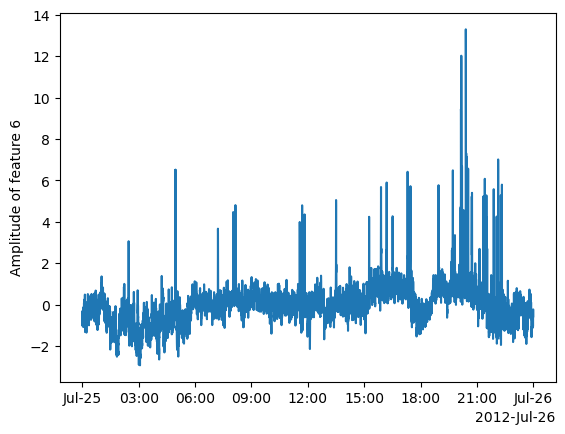

In [26]:
number_of_clusters = 5

# Perform clustering


### Feature direction in the scattering space

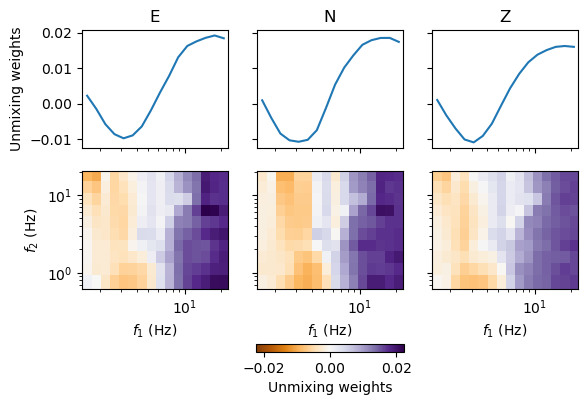

In [91]:
# Etract weights from the dimensionality reduction model
weights = dimension_model.components_[feature_id]
vmax = np.abs(weights).max()

# Scattering coefficients shape and frequencies
n_cha = 3
n_order_1 = network.banks[0].octaves * network.banks[0].resolution
n_order_2 = network.banks[1].octaves * network.banks[1].resolution
f_1 = network.banks[0].centers
f_2 = network.banks[1].centers

# Extract and reshape weights
order_1 = weights[: n_cha * n_order_1].reshape(n_cha, n_order_1)
order_2 = weights[n_cha * n_order_1 :].reshape(n_cha, n_order_1, n_order_2)

# Show weights
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey="row")
image_kw = dict(vmin=-vmax, vmax=vmax, rasterized=True, cmap="PuOr")
for id, channel in enumerate("ENZ"):

    # Show
    ax[0, id].plot(f_1, order_1[id], label=channel)
    mappable = ax[1, id].pcolormesh(f_1, f_2, order_2[id].T, **image_kw)

    # Labels
    ax[0, id].set_title(channel)
    ax[1, id].set_xlabel("$f_1$ (Hz)")

# Labels
ax[0, 0].set_ylabel("Unmixing weights")
ax[1, 0].set_ylabel("$f_2$ (Hz)")
ax[1, 0].set_xscale("log")
ax[1, 0].set_yscale("log")

# Colorbar
colorbar = fig.colorbar(mappable, orientation="horizontal", ax=ax, shrink=0.3)
colorbar.set_label("Unmixing weights")

# Show
plt.show()

## Reconstruction

We here reconstruct the scattering coefficients from a selected independent
components. We only show the first order coefficients, since the second order
coefficients are hard to map as a function of time. 

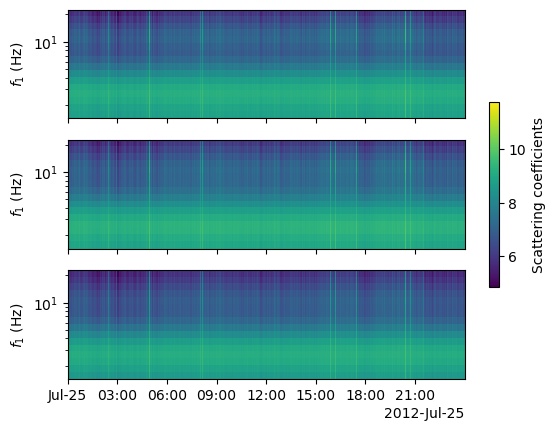

In [110]:
# Filter out latent space
features_filtered = np.zeros(features.shape)
features_filtered[:, feature_id] = feature

# Extract all scattering coefficients
reconstructed = dimension_model.inverse_transform(features_filtered)
reconstructed_order_1 = reconstructed[:, : n_cha * n_order_1].reshape(-1, n_cha, n_order_1)
vmin = reconstructed_order_1.min()
vmax = reconstructed_order_1.max()

# Plot
fig, ax = plt.subplots(nrows=3, sharex=True, sharey="row")

# Plot
for id, channel in enumerate("ENZ"):
    data = reconstructed_order_1[:, id, :].squeeze().T
    mappable = ax[id].pcolormesh(times, f_1, data, rasterized=True, vmin=vmin, vmax=vmax)
    ax[id].set_ylabel("$f_1$ (Hz)")
    ax[id].set_yscale("log")

# Colorbar
colorbar = fig.colorbar(mappable, orientation="vertical", ax=ax, shrink=0.5)
colorbar.set_label("Scattering coefficients")